# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '/Users/kc/Documents/milestone-4-roguesgallery/data/raw' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))
lst = pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))

## Task 0: Research Question

In [2]:
events['action'].unique()

array(['VIEW_QUESTION', 'SUBMIT_ANSWER', 'NEXT', 'GO_TO_THEORY', 'SKIP',
       'CLOSE', 'VIEW_SESSION_END', 'REVIEW_TASK', 'GO_TO_BUG_REPORT',
       'SHARE', 'ACCEPT_PROGRESS', 'GO_TO_COMMENTS', 'REJECT_PROGRESS',
       'NAVIGATE_DASHBOARD', 'LOGIN', 'LOGOUT', 'REQUEST_HINT',
       'PAGE_VISIT', 'WINDOW_OPEN', 'WINDOW_VISIBLE_TRUE',
       'WINDOW_VISIBLE_FALSE', 'WINDOW_CLOSE', 'SELECT_STATISTICS',
       'SUBMIT_SEARCH', 'GO_TO_SESSION', 'SHARE_SESSION', 'OPEN_FEEDBACK',
       'CLOSE_FEEDBACK', 'SURVEY_BANNER', 'PRETEST', 'NAVIGATE_SURVEY'],
      dtype=object)

{'CLOSE',
 'CLOSE_FEEDBACK',
 'GO_TO_BUG_REPORT',
 'GO_TO_COMMENTS',
 'GO_TO_THEORY',
 'NEXT',
 'OPEN_FEEDBACK',
 'REQUEST_HINT',
 'REVIEW_TASK',
 'SHARE',
 'SKIP',
 'SUBMIT_ANSWER',
 'VIEW_QUESTION'}

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [6]:
# Your code for data processing goes here

def remove_users(events, transactions):
    tokens_event = set(events['transaction_token'].unique())
    print("{} tokens in events".format(len(tokens_event)))

    tokens_trans = set(transactions['transaction_token'].unique())
    print("{} tokens in transactions".format(len(tokens_trans)))

    missing_tokens = list(tokens_event - tokens_trans)
    missing_tokens.remove(np.nan)
    print("{} tokens in events but not in transactions".format(len(missing_tokens)))

    users_missing = list(events[events['transaction_token'].isin(missing_tokens)]['user_id'].unique())
    print("{} users in events but not in transactions".format(len(users_missing)))

    # Events without missing users. Equivalent to removing the missing tokens from events.
    len_events = len(events)
    events = events[~events['user_id'].isin(users_missing)]
    stat_events = (len_events - len(events))/len_events
    print("{}% of events eliminated".format(round(stat_events, 4)))

    return events, transactions

events, transactions = remove_users(events, transactions)

637678 tokens in events
800018 tokens in transactions
37685 tokens in events but not in transactions
1304 users in events but not in transactions
0.0595% of events eliminated


### Cantonal representation within the data set

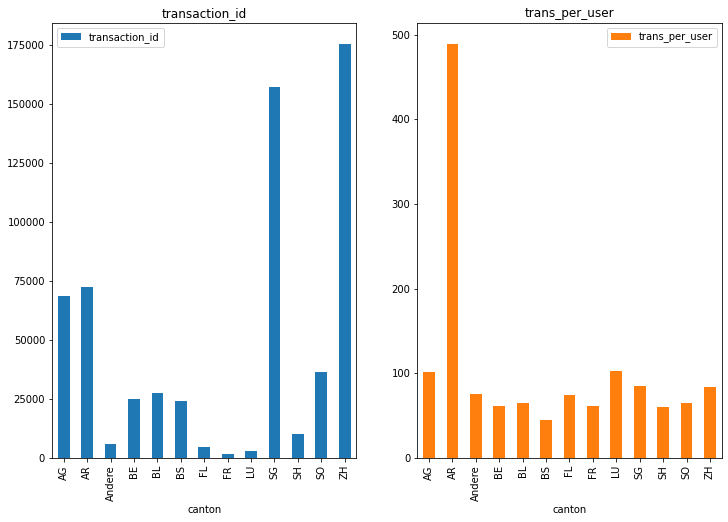

In [46]:
def activity_per(colname):
    
    users_per = users[['user_id', colname]]
    size_per = users_per.pivot_table(index=colname, values=['user_id'], aggfunc='nunique').reset_index()
    
    activity_per = transactions.merge(users_per, on='user_id', how='left')
    transactions_per = activity_per.pivot_table(index=colname, 
                                                values=['transaction_id', 'user_id'], 
                                                aggfunc={'transaction_id':'count', 'user_id':'nunique'}).reset_index()
    transactions_per['trans_per_user'] = transactions_per['transaction_id']/transactions_per['user_id']
    
    return users_per, size_per, transactions_per 



users_canton, canton_size, canton_transactions = activity_per('canton')
ax = canton_transactions.plot.bar(x='canton', 
                                  y=['transaction_id', 'trans_per_user'], 
                                  subplots=True, 
                                  layout=(1,2),
                                  figsize=(12,8))

<AxesSubplot:xlabel='canton'>

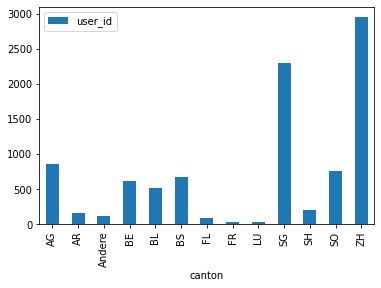

In [47]:
canton_size.plot.bar(x='canton', y='user_id')

These bar plots show us that cantons with greater numbers of students have a larger transaction count **overall**. However, most cantons, with the exception of AR show similar numbers of transactions *per user*.  

#### What's going on in AR?

<AxesSubplot:xlabel='class_level'>

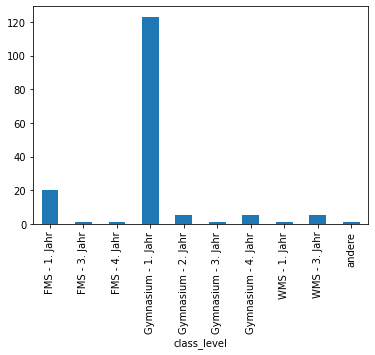

In [48]:
AR_users = users[users['canton'] == 'AR']
AR_levels = AR_users.groupby('class_level').count()['user_id']
AR_levels.plot.bar(x='class_level', y='user_id')

### Class (level) representation in the data set

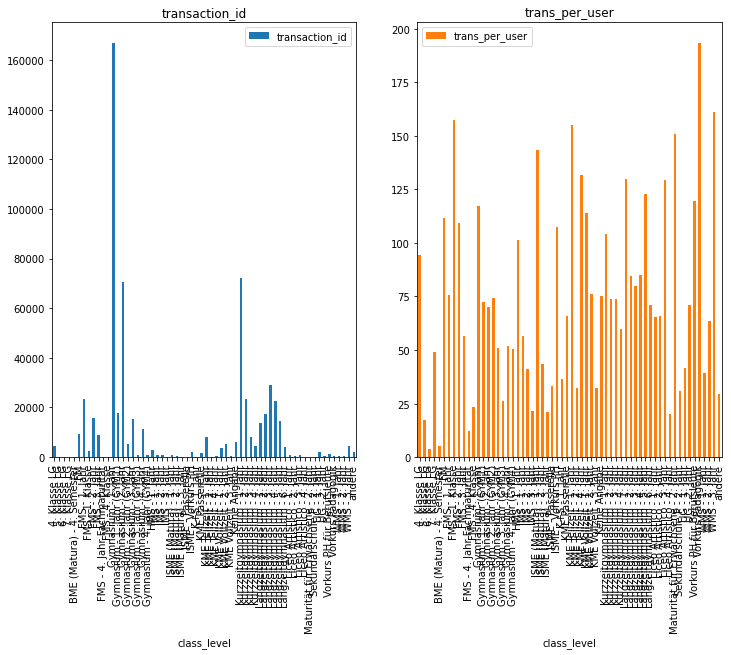

In [49]:
users_class, class_size, class_transactions = activity_per('class_level')

ax = class_transactions.plot.bar(x='class_level', 
                                 y=['transaction_id', 'trans_per_user'], 
                                 subplots=True, 
                                 layout=(1,2),
                                 figsize=(12,8)) #lots and lots of classes

In [41]:
#outliers 
def show_outliers(df, colname, method):
    
    if method == 'IQR':
        q1 = df[colname].quantile(0.25)
        q3 = df[colname].quantile(0.75)
        iqr = q3-q1
        lb = q1 - 1.5*iqr
        ub = q3 + 1.5*iqr
        
        print(f"Lower bound: {lb}")
        print(f"Upper bound: {ub}")
        
        out = df[(df[colname] < lb) | (df[colname] > ub)]
        
        return out
        
    if method == 'std':
        mean = df[colname].mean()
        std = df[colname].std()
        lb = mean - 1*std
        ub = mean + 1*std
        
        print(f"Lower bound: {lb}")
        print(f"Upper bound: {ub}")
        out = df[(df[colname] < lb) | (df[colname] > ub)]
        
        return out 

Lower bound: -188.75
Upper bound: 333.25


,class_level,user_id
6,FMS - 1. Jahr,379
13,Gymnasium - 1. Jahr,1852
14,Gymnasium - 1. Jahr (GYM1),336
15,Gymnasium - 2. Jahr,1179
17,Gymnasium - 3. Jahr,394
39,Kurzzeitgymnasium - 1. Jahr,945
40,Kurzzeitgymnasium - 2. Jahr,427
45,Langzeitgymnasium - 3. Jahr,481
46,Langzeitgymnasium - 4. Jahr,344


<AxesSubplot:>

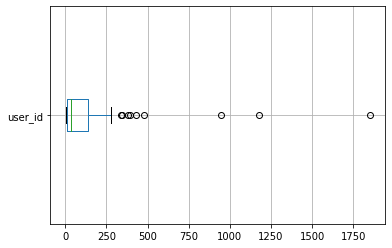

In [64]:
display(show_outliers(class_size, 'user_id', 'IQR'))
class_size.boxplot(column='user_id', vert=False)

Notice that the typical definition(s) for outliers do not exclude any classes at the lower end of the spectrum because there are many more classes with fewer numbers than higher ones. Therefore we will have to make a more precise and informed decision here. Of course classes with only one student (for example) will be poorly represented in the data set, therefore it would make sense to either group these students or remove them. 

In [37]:
display(show_outliers(class_transactions, 'transaction_id', 'IQR'))
display(show_outliers(class_transactions, 'trans_per_user', 'IQR')) #no outliers 

Q1: 309.0
Q3: 8833.25


,class_level,transaction_id,user_id,trans_per_user
6,FMS - 1. Jahr,23387,309,75.686084
12,Gymnasium - 1. Jahr,166834,1423,117.241040
14,Gymnasium - 2. Jahr,70635,1007,70.143992
38,Kurzzeitgymnasium - 1. Jahr,72257,693,104.266955
39,Kurzzeitgymnasium - 2. Jahr,23574,320,73.668750
44,Langzeitgymnasium - 3. Jahr,29109,365,79.750685
45,Langzeitgymnasium - 4. Jahr,22488,265,84.860377


Q1: 39.62591911764706
Q3: 106.56673881673882


,class_level,transaction_id,user_id,trans_per_user


We note that these outliers are all extremes in the right hand tail of the distribution.

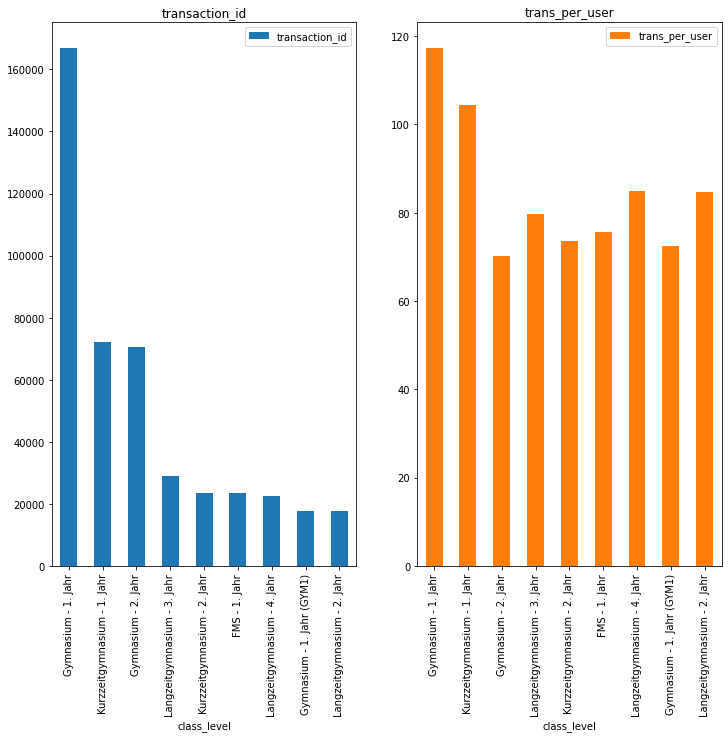

In [36]:
ax = class_transactions.sort_values(by=['transaction_id', 'trans_per_user'], 
                                    ascending=[False, False]) \
                        .iloc[0:9, :] \
                        .plot.bar(x='class_level',
                                  y=['transaction_id', 'trans_per_user'],
                                  subplots=True,
                                  layout=(1,2),
                                  figsize=(12,10))

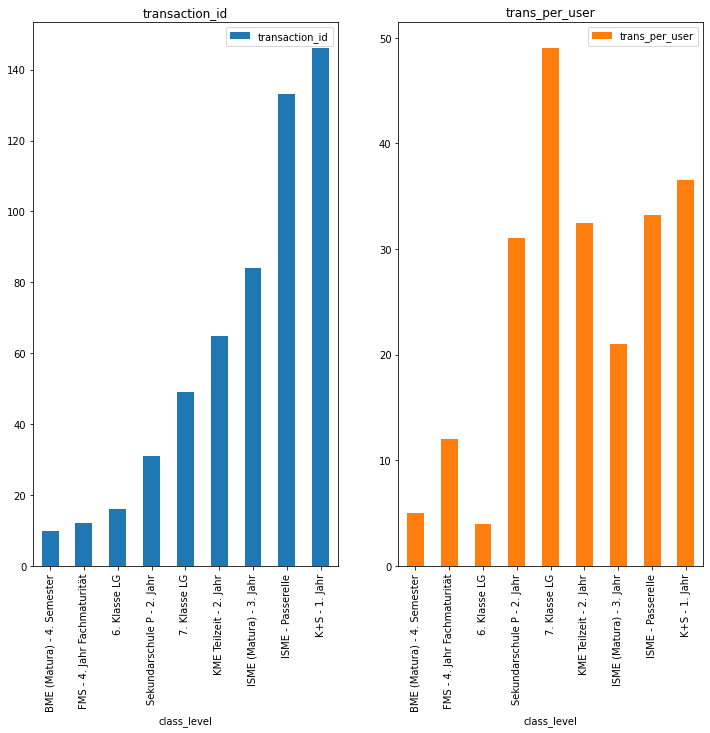

In [35]:
ax = class_transactions.sort_values(by=['transaction_id', 'trans_per_user'], 
                                    ascending=[True, True]) \
                        .iloc[0:9, :] \
                        .plot.bar(x='class_level',
                                  y=['transaction_id', 'trans_per_user'],
                                  subplots=True,
                                  layout=(1,2),
                                  figsize=(12,10))

---

In [5]:
def similarity_days(wi, wj):
    m1, m2 = np.where(wi == 1)[0], np.where(wj == 1)[0]
    if len(m1) == 0 or len(m2) == 0:
        return 0
    return len(np.intersect1d(m1, m2)) / max(len(m1), len(m2))

In [6]:
def chi2_divergence(p1, p2, a1, a2):
    a = p1 - p2
    b = p1 + p2
    frac = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b != 0)
    m1 = np.where(a1 > 0)[0]
    m2 = np.where(a2 > 0)[0]
    union = set(m1) & set(m2)
    if len(union) == 0: return np.nan
    return 1 - (1 / len(union)) * np.sum(np.square(frac))

In [7]:
from datetime import timedelta, datetime 
from scipy.spatial.distance import jensenshannon
from scipy import stats

In [8]:
def time_measures(data, mode, weeks):
    data = data[data['week'] < weeks]
    if mode == 'dayhour':
        hours = data['date'].dt.hour.astype(int).to_list()
        activity = np.array([hours.count(h) for h in np.arange(24)])
        if np.sum(activity) == 0:
            print("Feature is invalid: the dayhour mode is invalid. Returning nan.")
            return np.nan
        entropy = stats.entropy(activity / np.sum(activity))
        return (np.log(24) - entropy) * np.max(activity)
    elif mode == 'weekday':
        weekdays = data['date'].dt.weekday.astype(int).to_list()
        activity = np.array([weekdays.count(h) for h in np.arange(7)])
        if np.sum(activity) == 0:
            print("Feature is invalid: the weekday mode is invalid. Returning nan.")
            return np.nan
        entropy = stats.entropy(activity / np.sum(activity))
        return (np.log(7) - entropy) * np.max(activity)

In [9]:
def time_measures_plot_student(student, data, mode, weeks):
    data = data[data['user_id'] == student]
    data = data[data['week'] < weeks]
    if mode == 'dayhour':
        hours = data['date'].dt.hour.astype(int).to_list()
        activity = np.array([hours.count(h) for h in np.arange(24)])
        time_measure_data = pd.DataFrame({'hour' : np.arange(24), 'count' : activity})
        
        time_measure_data.plot.bar(x='hour', y='count', rot=0)
        plt.xlabel("Hour of day")
        plt.ylabel("Count")

    elif mode == 'weekday':
        weekdays = data['date'].dt.weekday.astype(int).to_list()
        activity = np.array([weekdays.count(h) for h in np.arange(7)])
        time_measure_data = pd.DataFrame({'weekday' : np.arange(7), 'count' : activity})
        
        time_measure_data.plot.bar(x='weekday', y='count', rot=0)
        plt.xlabel("Day of week")
        plt.ylabel("Count")  

In [10]:
def create_week_number(d):
    return (d.isocalendar()[0] - 2021) * 53 + d.isocalendar()[1] - 1
# https://stackoverflow.com/questions/59425176/how-to-continue-the-week-number-when-the-year-changes-using-pandas

In [11]:
def profile_similarity(data, mode, weeks):
    data['weekday'] = data['date'].dt.weekday.astype(int)
    data = data[data['week'] < weeks]
    
    workload = np.zeros((weeks, 7))
    workload[data['week'], data['weekday']] += 1
    hist = workload / np.sum(workload)

    # Hours of activity starting at midnight of the first timestamp
    hours = (data['date']).values.astype(np.int64) // 10 ** 9 // 3600
    min_day = data.date.min() # First day of activity
    # Make the hours start from midnight of the first day
    hours -= int(datetime(min_day.year, min_day.month, min_day.day).timestamp() / 3600)

    period_length = weeks * 7 * 24
    activity = np.array([int(t in hours) for t in range(period_length)]).reshape((weeks, 7 * 24))
    activity = np.array([week.reshape((7, 24)).sum(axis=1) for week in activity])  # shape (weeks, 7)
    if mode == 'm1':
        return np.mean([similarity_days(workload[i], workload[j]) for i in range(workload.shape[0]) for j in range(i+1, workload.shape[0])])
    elif mode == 'm2':
        res = []
        for i in range(activity.shape[0]):
            for j in range(i + 1, activity.shape[0]):
                if not activity[i].any() or not activity[j].any():
                    continue
                res.append(1 - jensenshannon(activity[i], activity[j], 2.0))
        if len(res) == 0:
            #print("Feature is invalid. Will return nan")
            return np.nan
        return np.mean(np.clip(np.nan_to_num(res), 0, 1))
    elif mode == 'm3':
        res = []
        for i in range(activity.shape[0]):
            for j in range(i + 1, activity.shape[0]):
                if not activity[i].any() or not activity[j].any():
                    continue
                res.append(chi2_divergence(activity[i], activity[j], hist[i], hist[j]))
        if len(res) == 0:
            return np.nan
        return np.mean(np.nan_to_num(res))

---

In [12]:
def fourier_transform(Xi, f, n):
    return np.dot(np.exp(-2j * np.pi * f * n), Xi)

In [13]:
def freq(data, mode, weeks):
    if mode == 'm1':
        # Convert date to hours starting from 0
        hours = data['date'].values.astype(np.int64) // 10 ** 9 // 3600
        hours -= min(hours)
        period_length = weeks * 7 * 24
        activity = np.array([int(t in hours) for t in range(period_length)])  # 1 if active at hour t 0 o.w.
        if np.sum(activity) == 0:
            #logging.debug('feature {} is invalid: the m1 mode is invalid'.format(self.name))
            return np.nan #Feature.INVALID_VALUE
        n = np.arange(period_length)
        return abs(fourier_transform(activity, 1 / 24, n))

    elif mode == 'm2':
        period_length = weeks * 7 * 24
        hours = data['date'].values.astype(np.int64) // 10 ** 9 // 3600
        hours -= min(hours)
        activity = np.array([int(t in hours) for t in range(period_length)])
        n = np.arange(period_length)
        return abs(fourier_transform(activity.flatten(), 1 / (7 * 24), n))

    elif mode == 'm3':
        # Convert date to days starting from 0
        days = data['date'].values.astype(np.int64) // 10 ** 9 // (24 * 3600)
        days -= min(days)
        period_length = weeks * 7
        activity = np.array([int(d in days) for d in range(period_length)])  # 1 if active at day d 0 o.w.
        n = np.arange(period_length)
        return abs(fourier_transform(activity, 1 / 7, n))

In [79]:
def compute_agg_regularity(data, weeks):
    
    #time based measures
    PDH = data.groupby('user_id').apply(lambda x: time_measures(x, 'dayhour', weeks)).reset_index()
    PWD = data.groupby('user_id').apply(lambda x: time_measures(x, 'weekday', weeks)).reset_index(drop=True)
    
    #profile similarity 
    WS1 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm1', weeks)).reset_index(drop=True)
    WS2 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm2', weeks)).reset_index(drop=True)
    WS3 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm3', weeks)).reset_index(drop=True)
    
    #frequency based measures
    FDH = data.groupby('user_id').apply(lambda x: freq(x, 'm1', weeks)).reset_index(drop=True)
    FWH = data.groupby('user_id').apply(lambda x: freq(x, 'm2', weeks)).reset_index(drop=True)
    FWD = data.groupby('user_id').apply(lambda x: freq(x, 'm3', weeks)).reset_index(drop=True)
    
    reg_features = pd.concat([PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD], axis=1, ignore_index=False)
    
    return reg_features 

---

In [80]:
data_clean = pd.read_csv('{}/data_clean.csv.gz'.format(DATA_DIR))
data_clean.rename(columns={'timestamp':'date'}, inplace=True)
data_clean['date'] = pd.to_datetime(data_clean['date']) 

,user_id,date,week,category,action,start_time,commit_time,max_num_tasks,num_checks,num_participations,num_actions_per_week,num_weeks_per_user
0,387604.0,2022-02-18 15:13:38.387,40,SESSION,REVIEW_TASK,1645197218251,1.645197e+12,5,11,5,7,6
1,387604.0,2022-02-18 15:13:40.545,40,SESSION,SKIP,1645197218251,1.645197e+12,5,11,5,7,6
2,387604.0,2022-02-18 15:13:43.057,40,SESSION,REVIEW_TASK,1645197222948,NaN,5,11,5,7,6
3,387604.0,2022-02-18 15:13:30.415,40,SESSION,REVIEW_TASK,1645197210317,1.645197e+12,5,11,5,7,6
4,387604.0,2022-02-18 15:13:37.975,40,SESSION,SKIP,1645197210317,1.645197e+12,5,11,5,7,6


In [81]:
#data_clean.info()
data_clean.drop(['start_time', 'commit_time'], axis=1, inplace=True)

In [82]:
no_weeks = max(data_clean.week) + 1
reg_features = compute_agg_regularity(data_clean, no_weeks)

In [83]:
reg_features.head()

,user_id,0,0,1,2,3,4,5,6
0,387604.0,27.942484,14.605581,0.003871,0.188178,0.0,11.820073,9.180426,5.166201
1,387605.0,164.753993,106.877243,0.015292,0.162790,0.0,13.732957,10.321867,4.791290
2,387608.0,114.246372,21.449510,0.001161,0.100000,0.0,6.883195,2.297492,1.519203
3,387644.0,147.319940,127.641763,0.000581,0.322395,0.0,3.797918,2.432918,2.027293
4,387650.0,97.469260,49.102222,0.015970,0.245105,0.0,13.622891,5.177756,4.932190


In [84]:
reg_features.columns = ['user_id', 'PDH', 'PWD', 'WS1', 'WS2', 'WS3', 'FDH', 'FWH', 'FWD']
reg_features.head()

,user_id,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
0,387604.0,27.942484,14.605581,0.003871,0.188178,0.0,11.820073,9.180426,5.166201
1,387605.0,164.753993,106.877243,0.015292,0.162790,0.0,13.732957,10.321867,4.791290
2,387608.0,114.246372,21.449510,0.001161,0.100000,0.0,6.883195,2.297492,1.519203
3,387644.0,147.319940,127.641763,0.000581,0.322395,0.0,3.797918,2.432918,2.027293
4,387650.0,97.469260,49.102222,0.015970,0.245105,0.0,13.622891,5.177756,4.932190


In [85]:
#some descriptive stats
reg_features.drop('user_id', axis=1).describe()

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
count,2656.000000,2656.000000,2656.000000,2476.000000,2476.000000,2.656000e+03,2656.000000,2.656000e+03
mean,203.521843,182.799484,0.003355,0.323830,0.005603,5.720714e+00,4.942490,2.698046e+00
std,173.186375,203.468056,0.008354,0.322900,0.087413,5.711670e+00,5.121061,2.363010e+00
min,8.710755,6.315072,0.000000,0.000000,-1.250000,5.229633e-16,0.186727,4.965068e-16
25%,90.034079,62.088950,0.000000,0.000000,0.000000,2.710363e+00,2.080551,1.414214e+00
50%,154.298030,121.304532,0.001161,0.262427,0.000000,3.965779e+00,3.432022,2.000000e+00
75%,261.286674,223.779665,0.002323,0.443133,0.000000,6.616035e+00,5.594695,3.000000e+00
max,1364.971115,3062.141604,0.079752,1.000000,1.000000,6.951391e+01,51.765318,1.870196e+01


In [90]:
reg_features.drop('user_id', axis=1).corr()

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
PDH,1.000000,0.661052,0.347986,0.211583,0.122882,0.290867,0.283191,0.349597
PWD,0.661052,1.000000,0.543699,0.292506,0.039472,0.373046,0.531588,0.522008
WS1,0.347986,0.543699,1.000000,0.146237,-0.078301,0.754746,0.787021,0.863204
WS2,0.211583,0.292506,0.146237,1.000000,0.178355,0.003762,0.109581,0.200993
WS3,0.122882,0.039472,-0.078301,0.178355,1.000000,-0.107785,-0.092193,-0.067743
FDH,0.290867,0.373046,0.754746,0.003762,-0.107785,1.000000,0.766441,0.689512
FWH,0.283191,0.531588,0.787021,0.109581,-0.092193,0.766441,1.000000,0.897766
FWD,0.349597,0.522008,0.863204,0.200993,-0.067743,0.689512,0.897766,1.000000


In [94]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [96]:
calculate_pvalues(reg_features.drop('user_id', axis=1))  #strongly correlated features all over the shop. 

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
PDH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PWD,0.0,0.0,0.0,0.0,0.0495,0.0,0.0,0.0
WS1,0.0,0.0,0.0,0.0,0.0001,0.0,0.0,0.0
WS2,0.0,0.0,0.0,0.0,0.0,0.8516,0.0,0.0
WS3,0.0,0.0495,0.0001,0.0,0.0,0.0,0.0,0.0007
FDH,0.0,0.0,0.0,0.8516,0.0,0.0,0.0,0.0
FWH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FWD,0.0,0.0,0.0,0.0,0.0007,0.0,0.0,0.0


---

In [108]:
reg_features.to_csv('user_reg_features.csv.gz', compression='gzip', index=False)

In [106]:
import os
os.getcwd()
os.chdir('/Users/kc/Documents/milestone-4-roguesgallery/data/raw')

---

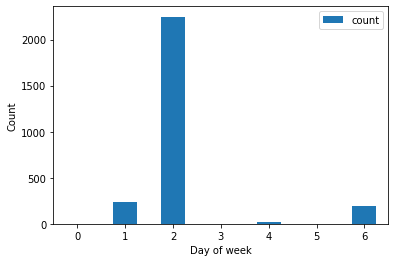

In [86]:
idx = reg_features['PWD'].idxmax()
student_clean = reg_features['user_id'].loc[idx]
time_measures_plot_student(student_clean, data_clean, 'weekday', no_weeks)

612

## Task 2: Model Building

Train a model for your research question. 

In [ ]:
# Your code for training a model goes here

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*